<a id='top'></a>

<a id='index'></a>

<h1>COVID19 World and Italy monitor<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notebook-Description" data-toc-modified-id="Notebook-Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notebook Description</a></span></li><li><span><a href="#Italy-Monitor" data-toc-modified-id="Italy-Monitor-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Italy Monitor</a></span><ul class="toc-item"><li><span><a href="#Provinces" data-toc-modified-id="Provinces-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Provinces</a></span><ul class="toc-item"><li><span><a href="#Mortality-analysis-for-first-quarter-of-2020" data-toc-modified-id="Mortality-analysis-for-first-quarter-of-2020-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Mortality analysis for first quarter of 2020</a></span></li><li><span><a href="#Top-provinces-for-the-day" data-toc-modified-id="Top-provinces-for-the-day-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Top provinces for the day</a></span></li><li><span><a href="#Provinces-analysis-per-region" data-toc-modified-id="Provinces-analysis-per-region-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Provinces analysis per region</a></span></li></ul></li><li><span><a href="#Regional-analysis" data-toc-modified-id="Regional-analysis-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Regional analysis</a></span><ul class="toc-item"><li><span><a href="#Daily-cases" data-toc-modified-id="Daily-cases-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Daily cases</a></span></li><li><span><a href="#Total-cases-decomposition" data-toc-modified-id="Total-cases-decomposition-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Total cases decomposition</a></span></li><li><span><a href="#Evolution-analysis" data-toc-modified-id="Evolution-analysis-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Evolution analysis</a></span></li><li><span><a href="#Model-fitting" data-toc-modified-id="Model-fitting-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Model fitting</a></span></li></ul></li></ul></li><li><span><a href="#World-Monitor" data-toc-modified-id="World-Monitor-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>World Monitor</a></span><ul class="toc-item"><li><span><a href="#Top-countries" data-toc-modified-id="Top-countries-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Top countries</a></span></li><li><span><a href="#Total-cases-decomposition" data-toc-modified-id="Total-cases-decomposition-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Total cases decomposition</a></span></li><li><span><a href="#Country-comparisons" data-toc-modified-id="Country-comparisons-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Country comparisons</a></span></li><li><span><a href="#Model-fitting" data-toc-modified-id="Model-fitting-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Model fitting</a></span></li><li><span><a href="#SEIRD-Epidemioligic-Model-Simulator" data-toc-modified-id="SEIRD-Epidemioligic-Model-Simulator-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>SEIRD Epidemioligic Model Simulator</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#begin-remove-section" data-toc-modified-id="begin-remove-section-3.5.0.1"><span class="toc-item-num">3.5.0.1&nbsp;&nbsp;</span>begin remove section</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Notebook Description

<img src="image.png">

This repo contains analysis built around data about global and italian diffusion of COVID-19 that might be useful in monitoring the spread of coronavirus around the world.

This monitor does not by any means intend to provide any attempt to predict future evolutions of the virus but only to offer a visual tool to capture its dynamics.

Data are automatically downloaded from publicly available repos such as:

1) John Hopkins CSSE (https://github.com/CSSEGISandData/COVID-19) for world data

2) Protezione Civile Italiana (https://github.com/pcm-dpc/COVID-19) for national data

Just scroll down the notebook to perform various analysis on both worldwide and italian data

Code available at my repo:
https://github.com/mspadaccino/COVID-19

(jupyter notebook and code by Maurizio Spadaccino, april 2020)

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import types
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from src.models import func_log, func_gomp, func_exp, func_ext_log, func_pol
import inspect
import plotly.express as px
from sklearn.linear_model import LinearRegression
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from src.data_downloader import DATA_REPOS, download_from_repo
from src.tools import add_extra_features
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import plotly.graph_objects as go
from plotly.graph_objs import Layout
from plotly.subplots import make_subplots
import ast
#import folium
#from fuzzywuzzy import fuzz, process
pd.set_option('display.max_columns', None)

In [2]:
dest='../data'

In [3]:
print('updating datasets from repos...')
print('downloading Italian data')
download_from_repo(DATA_REPOS['italy']['url'], filenames=DATA_REPOS['italy']['streams'], dest=dest)
print('downloading world data')
download_from_repo(DATA_REPOS['world']['url'], filenames=DATA_REPOS['world']['streams'], dest=dest)

updating datasets from repos...
downloading Italian data
updated  /dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv
updated  /dati-regioni/dpc-covid19-ita-regioni.csv
updated  /dati-province/dpc-covid19-ita-province.csv
could not retrieve repo infos,  Error -5 while decompressing data: incomplete or truncated stream
downloading world data
updated  /csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
updated  /csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
updated  /csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv
last commit  2020-05-01 04:55:43


In [4]:
# uncomment this to change xls to faster loading csv for istat data
#df_comuni_sett = pd.read_excel(os.path.join(dest, 'comuni_settimana.xlsx'))
#df_comuni_sett.to_csv('df_comuni_sett.csv')

In [5]:
# loading datasets
df_naz = pd.read_csv(os.path.join(dest,'dpc-covid19-ita-andamento-nazionale.csv')).drop('stato',1)
print('last available date for Italy data',df_naz['data'].iloc[-1])
reg = pd.read_csv(os.path.join(dest,'dpc-covid19-ita-regioni.csv'))
prov = pd.read_csv(os.path.join(dest,'dpc-covid19-ita-province.csv')).drop('stato',1)
df_naz.index = pd.to_datetime(df_naz.index)
reg['data'] = pd.to_datetime(reg['data'])
prov['data'] = pd.to_datetime(prov['data'])
# df_comuni_sett = pd.read_excel(os.path.join(dest, 'comuni_settimana.xlsx'))
df_comuni_sett = pd.read_csv(os.path.join(dest, 'df_comuni_sett.csv'))
df_world_confirmed = pd.read_csv(os.path.join(dest,'time_series_covid19_confirmed_global.csv'))
df_world_deaths = pd.read_csv(os.path.join(dest,'time_series_covid19_deaths_global.csv'))
df_world_recovered = pd.read_csv(os.path.join(dest,'time_series_covid19_recovered_global.csv'))
populations = pd.read_csv(os.path.join(dest,'API_SP.POP.TOTL_DS2_en_csv_v2.csv'), skiprows=4, engine='python').set_index('Country Name')['2018']
ita_populations = pd.read_csv(os.path.join(dest,'popitaregions.csv'))
df_world_confirmed['pop'] = df_world_confirmed['Country/Region'].map(populations)
df_world_deaths['pop'] = df_world_deaths['Country/Region'].map(populations)
df_world_recovered['pop'] = df_world_recovered['Country/Region'].map(populations)
print('last available date for World data',df_world_confirmed.columns[-2])
df_naz = add_extra_features(df_naz)
regions = reg.groupby('denominazione_regione')
df_reg = {}
df_reg['Italy'] = df_naz
for item in regions.groups:
    df_reg[item] = add_extra_features(regions.get_group(item)).replace((np.inf, np.nan), 0)

provinces = prov.groupby('sigla_provincia')
df_prov = pd.DataFrame()
for item in provinces.groups:
    df_prov = pd.concat((df_prov,add_extra_features(provinces.get_group(item)).replace((np.inf, np.nan), 0)),0)


last available date for Italy data 2020-04-30T17:00:00
last available date for World data 4/30/20


In [6]:
#fixing country and province different names from different datasets
pop_replace = [('US', 'United States'), ('Korea, South', 'Korea, Rep.'), 
               ('Venezuela','Venezuela, RB'), ('Bahamas','Bahamas, The'), 
               ('Iran','Iran, Islamic Rep.'), ('Russia','Russian Federation'), 
               ('Egypt','Egypt, Arab Rep.'), ('Syria','Syrian Arab Republic'),
               ('Slovakia','Slovak Republic'),('Czechia','Czech Republic'),
               ('Congo (Brazzaville)','Congo, Rep.'),
               ('Congo (Kinshasa)','Congo, Dem. Rep.'),('Kyrgyzstan','Kyrgyz Republic'),
               ('Laos','Lao PDR'),('Brunei','Brunei Darussalam'),
               ('Gambia', 'Gambia, The')]
for item in pop_replace:
    try:
        populations.loc[item[0]] = populations.loc[item[1]]
        del populations[item[1]]
    except Exception as e:
        print(e)
        
pops = ita_populations.loc[ita_populations['Regione']=='Trentino-Alto Adige', ['Popolazione','Superficie sqkm','ab/sqkm','Numero_comuni','Numero_province']].values/2
newdf = pd.DataFrame(index = ['P.A. Trento', 'P.A. Bolzano', 'Italy'], columns=ita_populations.set_index('Regione').columns)
newdf.loc['P.A. Trento']=pops[0]
newdf.loc['P.A. Bolzano']=pops[0]
newdf.loc['Italy']= [populations.loc['Italy'], 0., 0., 0., 0.]
newdf.reset_index(inplace=True)
newdf.rename(columns={'index': 'Regione'}, inplace=True)
ita_populations = pd.concat((ita_populations,newdf)).set_index('Regione')

In [7]:
# defining labels for use in next functions
orig_data_columns = ['ricoverati_con_sintomi','terapia_intensiva','totale_ospedalizzati','isolamento_domiciliare',
                    'totale_positivi',
                     #'variazione_totale_positivi',
                     'nuovi_positivi',
                     'dimessi_guariti','deceduti','totale_casi','tamponi','casi_testati']                    
extra_data_columns = ['growth_factor','deceduti_su_tot','deceduti_su_dimessi', 'totale_casi_su_tamponi',
                      'totale_ospedalizzati_su_tamponi','deceduti_su_tamponi', 'casi_testati_su_tamponi',
                      'deceduti_su_casi_testati', 'totale_casi_su_casi_testati', 'totale_ospedalizzati_su_casi_testati']
delta_data_columns = ['daily_'+item for item in orig_data_columns]
percent_delta_data_columns = ['%daily_'+item for item in orig_data_columns]
data_columns = orig_data_columns + extra_data_columns + delta_data_columns + percent_delta_data_columns
prov_data_columns = ['totale_casi', 'daily_totale_casi', '%daily_totale_casi', 'growth_factor']
models = {'gompertz': func_gomp, 'logistic':func_log, 'extended logistic':func_ext_log, 
          'exponential':func_exp, 'log_linear': 'log', 'no_fit':'actual'}
countries_columns = df_world_confirmed['Country/Region'].unique()
countries_labels = ['confirmed', 'recovered', 'deaths', 'daily_confirmed', 'daily_recovered', 'daily_deaths',
                   '%daily_confirmed', '%daily_recovered', '%daily_deaths']

# Italy Monitor

## Provinces

### Mortality analysis for first quarter of 2020

In [36]:
provinces = widgets.Dropdown(options=['all'])
cities = widgets.Dropdown(options=['all'])

def get_provinces(item):
    if item == 'Italy':
        provinces.options=['all']
    else:
        provinces.options=['all']+list(df_comuni_sett[df_comuni_sett['NOME_REGIONE']==item]['NOME_PROVINCIA'].unique())
def get_cities(item1,item2):
    if item1 == 'Italy':
        cities.options=['all']
    else:
        cities.options=['all']+list(df_comuni_sett[(df_comuni_sett['NOME_REGIONE']==
                    item1) & (df_comuni_sett['NOME_PROVINCIA']==item2)]['NOME_COMUNE'].unique())

@interact
def plot_weekly_deaths(region = ['Italy'] + list(df_comuni_sett['NOME_REGIONE'].unique()),
                       province = provinces,
                       city = cities,
                       show_excess_deaths = False):
    get_provinces(region)
    get_cities(region,province)
    if region == 'Italy':
        province = ['all']
        city = ['all']
        get_provinces(region)
        get_cities(region,province)
    df_prov_deaths = df_comuni_sett.groupby(['NOME_REGIONE','NOME_PROVINCIA','NOME_COMUNE', 'SETTIMANA']).sum()[[item for item in df_comuni_sett.columns if 'TOTALE' in item]]
    df_prov_deaths['excess_over_avg'] = df_prov_deaths['TOTALE_2020'] - df_prov_deaths[df_prov_deaths.columns[:-1]].mean(1)
    if region == 'Italy':
        tempdf =df_prov_deaths.reset_index().groupby('SETTIMANA').sum()
    elif province == 'all':
        tempdf = df_prov_deaths.loc[region].reset_index().groupby('SETTIMANA').sum()
    elif city == 'all':
        tempdf = df_prov_deaths.loc[region, province].reset_index().groupby('SETTIMANA').sum()    
    else:
        tempdf = df_prov_deaths.loc[region, province, city].reset_index().groupby('SETTIMANA').sum()
    tempdf['start_week'] = [item[:5] for item in tempdf.index]
    tempdf['start_week'] = tempdf['start_week'].apply(lambda x: datetime.datetime.strptime(x, '%d/%m'))
    tempdf.sort_values(by='start_week',inplace=True)
    tempdf.drop(['start_week'], axis=1, inplace=True)
    if show_excess_deaths:
        fig = make_subplots(rows=2, cols=1)    
    else:
        fig = go.Figure()
    for item in [item for item in tempdf.columns[:-1]]:
        fig.add_trace(go.Scatter(x=tempdf.index, y=tempdf[item], name=item, fill='tozeroy', opacity=0.2))
    fig.update_layout(title={
        'text': 'weekly deaths for 2015-2020 for {}, {}, {}, excess deaths on 2020 {}'.format(region, province, city, 
            int(tempdf['excess_over_avg'].sum())),
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            paper_bgcolor='rgba(0,0,0,0)',font = dict(color = 'lightgray'),plot_bgcolor='rgba(0,0,0,0)'
                 )
    fig.update_xaxes(showgrid=False, gridwidth=1, gridcolor='gray')
    fig.update_yaxes(showgrid=False, gridwidth=1, gridcolor='gray')

    if show_excess_deaths:
        fig.add_trace(go.Bar(x=tempdf.index, y=tempdf['excess_over_avg'], 
                    name='excess_deaths', opacity=1, marker_color='indianred'),
                             row=2, col=1)


    fig.show()

interactive(children=(Dropdown(description='region', options=('Italy', 'Piemonte', "Valle d'Aosta/Vallée d'Aos…

[Top](#index)

In [37]:
df_prov_deaths = df_comuni_sett.groupby(['NOME_REGIONE','NOME_PROVINCIA']).sum()[[item for item in df_comuni_sett.columns if 'TOTALE' in item]]
df_prov_deaths['avg'] = df_prov_deaths[df_prov_deaths.columns[:-1]].mean(1)
df_prov_deaths['excess_over_avg'] = df_prov_deaths['TOTALE_2020'] - df_prov_deaths['avg'] 
df_prov_deaths['excess_over_avg%'] = df_prov_deaths['excess_over_avg'] / df_prov_deaths['avg']  
df_prov_deaths['excess'] = df_prov_deaths['excess_over_avg'].apply(lambda x: max(0, x)).astype(int)
df_prov_deaths = df_prov_deaths.reset_index()#.drop(['NOME_REGIONE'],1)[['NOME_PROVINCIA','excess_over_avg', 'excess_over_avg%', 'avg', 'TOTALE_2020']]
df_prov_deaths = df_prov_deaths.merge(df_prov.groupby('denominazione_provincia').agg({'lat':'first', 'long':'first'}),left_on='NOME_PROVINCIA', right_index=True, how='left')
df_prov_deaths.loc[df_prov_deaths['NOME_PROVINCIA']=='Reggio Calabria', 'NOME_PROVINCIA'] = 'Reggio di Calabria'
df_prov_deaths = df_prov_deaths.set_index('NOME_PROVINCIA').append(pd.DataFrame(index=['Bolzano/Bozen', 'Prato', 'Rieti', 'Trieste'], columns=df_prov_deaths.columns)).fillna(0).reset_index()
# fig = px.scatter_mapbox(df_prov_deaths, 
#             lat='lat', lon='long', color='excess_over_avg', size='excess',
#             labels = 'excess_over_avg%',
#             hover_name='NOME_PROVINCIA',
#             zoom=4.5,  height=800,
#             mapbox_style="open-street-map",                        
#             title='excess mortality in 1Q-2020 over average 2015-19 for provinces',
#    )
# fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',font = dict(color = 'lightgray'))
# fig.show()
fig = px.choropleth(df_prov_deaths, 
                    geojson='https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_provinces.geojson', 
                    locations='index', 
                    color='excess_over_avg', 
                    color_continuous_scale='Reds', 
                    featureidkey='properties.prov_name',                                   
                    range_color=(0, max(df_prov_deaths['excess_over_avg'])))
# fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(showlegend=True,title='Geographical representation of excess mortality across italian provinces',
                  paper_bgcolor='rgba(0,0,0,0)',font = dict(color = 'lightgray'),plot_bgcolor='rgba(0,0,0,0)')
fig.update_geos(resolution=50, showcountries=True, countrycolor="lightgray", showland=True, 
                landcolor="Black", showsubunits=True, subunitcolor="Blue", showocean=True, oceancolor="Black",)
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

[Top](#index)

### Top provinces for the day

In this section you can view on any selected date, the geographical distribution around the italian provinces.

See which provinces recorder the highest number of selected cases for the day:

In [38]:
@interact
def get_top_provinces(label= prov_data_columns, 
                      top_prov=widgets.IntSlider(min=1,max=50,step=1,value=20), date=widgets.DatePicker(
                      description='Pick a Date',value=pd.to_datetime(df_prov.index.max())),
                      show_map=True, show_grid=False):
    try:
        df_prov.index = pd.to_datetime(df_prov.index)

        if len(label) == 0:
            label = prov_data_columns[:1]
        label = list([label])

        tempdf = df_prov.loc[str(date)][['sigla_provincia','denominazione_provincia', 'lat', 'long']+ label].sort_values(by=label, 
             ascending=False)[:top_prov].set_index('sigla_provincia')

        if show_map:
            fig = px.scatter_mapbox(tempdf, 
#                         lat='lat', lon='long', z=label[0], radius=10, 
                        lat='lat', lon='long', color=label[0], size=label[0],
                        labels = label[0],
                        hover_name='denominazione_provincia',
                        zoom=4.5,  height=800,
                        mapbox_style="open-street-map",                        
                        title='top {} provinces on day {} for {}'.format(top_prov, date.strftime("%m/%d/%Y"), label[0]),
               )
            fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',font = dict(color = 'lightgray'))
            fig.show()
        else:
            fig = px.bar(tempdf[label].reset_index(), x=label[0], y='sigla_provincia', orientation='h')
            fig.update_layout(showlegend=True,title='top {} provinces on day {}'.format(top_prov, date.strftime("%m/%d/%Y")),
                             paper_bgcolor='rgba(0,0,0,0)',font = dict(color = 'lightgray'),plot_bgcolor='rgba(0,0,0,0)')
            fig.update_xaxes(showgrid=show_grid, gridwidth=1, gridcolor='gray')
            fig.update_yaxes(showgrid=show_grid, gridwidth=1, gridcolor='gray')

            fig.show()
    except Exception as e:
        print(e)

interactive(children=(Dropdown(description='label', options=('totale_casi', 'daily_totale_casi', '%daily_total…

[Top](#index)

### Provinces analysis per region

In this monitor, we can analyse virus statistics for the provinces in each of the selected region on a given date:

In [39]:
@interact
def get_prov_data(label=prov_data_columns, region = list(df_prov.denominazione_regione.unique()),date=widgets.DatePicker(
                      description='Pick a Date',value=pd.to_datetime(df_prov.index.max())), show_grid=False):
    try:
        df_prov.index = pd.to_datetime(df_prov.index)
        if isinstance(df_prov.groupby('denominazione_regione').get_group(region).loc[date
            ], pd.Series):
            temp = pd.DataFrame(df_prov.groupby('denominazione_regione').get_group(region).loc[date]).T
        else:    
            temp = df_prov.groupby('denominazione_regione').get_group(region).loc[date
            ].set_index('denominazione_provincia')[label].sort_values()#.plot(kind='barh', 
        fig = px.bar(temp.reset_index(), x=label, y='denominazione_provincia', orientation='h')
        fig.update_layout(showlegend=True,title='{} on day {}'.format(label, date.strftime("%m/%d/%Y")),
                             paper_bgcolor='rgba(0,0,0,0)',font = dict(color = 'lightgray'),plot_bgcolor='rgba(0,0,0,0)')
        fig.update_xaxes(showgrid=show_grid, gridwidth=1, gridcolor='lightgray')
        fig.update_yaxes(showgrid=show_grid, gridwidth=1, gridcolor='lightgray')

        fig.show()
    except Exception as e:
        print(e)

interactive(children=(Dropdown(description='label', options=('totale_casi', 'daily_totale_casi', '%daily_total…

[Top](#top)

## Regional analysis

### Daily cases

In this monitor, you can compare data on a given date for one or more regions on both absolute and relative values). 

Please note: more items can be selected, on both region and data fields.

In [40]:
@interact
def get_values_for_day(regions = widgets.SelectMultiple(description="regions",options=list(df_reg.keys())),
                       labels = widgets.SelectMultiple(description="data",options=data_columns),
                       date=widgets.DatePicker(description='Pick a Date',value=pd.to_datetime(df_prov.index.max())),
                       cases_per_mln_people=False, show_grid=False):
    try:
        if len(regions) == 0:
            regions = ['Italy']
        regions = list(regions)    
        if len(labels) == 0:
            labels = [item for item in data_columns if ('daily' in item) & ('%' not in item)]
        labels = list(labels)
        mult = 1.
        fig = go.Figure()
        for region in regions:    
            if cases_per_mln_people: 
                mult = 1e06/ita_populations.loc[region, 'Popolazione']
            for item in labels: 
                df_reg[region].index = pd.to_datetime(df_reg[region].index)
            fig.add_traces(go.Bar(y=labels, x=df_reg[region][labels].loc[date]*mult, name=region, orientation='h'))
            fig.update_layout(showlegend=True,title='day ' + str(date.strftime("%m/%d/%Y")),
                             paper_bgcolor='rgba(0,0,0,0)',font = dict(color = 'lightgray'),plot_bgcolor='rgba(0,0,0,0)')
        fig.update_xaxes(showgrid=show_grid, gridwidth=1, gridcolor='lightgray')
        fig.update_yaxes(showgrid=show_grid, gridwidth=1, gridcolor='lightgray')
        fig.show()
    except Exception as e:
        print(e)

interactive(children=(SelectMultiple(description='regions', options=('Italy', 'Abruzzo', 'Basilicata', 'Calabr…

[Top](#top)

### Total cases decomposition

In [42]:
@interact
def get_regional_pie(region = df_reg.keys(),
                     case = ['totale casi', 'attualmente positivi'],
                     date=widgets.DatePicker(description='Pick a Date',value=pd.to_datetime(df_reg['Italy'].index.max())),):
    try:
        if len(region) == 0:
            region = 'Italy'
        if case == 'attualmente positivi':
            labels = ['ricoverati_con_sintomi','terapia_intensiva', 'isolamento_domiciliare']
        else:
            labels = ['totale_positivi','dimessi_guariti', 'deceduti']

        df_reg[region].index = pd.to_datetime(df_reg[region].index)
        fig = px.pie(df_reg[region].loc[str(date)], labels=labels, names=labels, 
                     values = df_reg[region][labels].loc[str(date)].values, 
                     title = '{} decomposition on date {} for {}'.format(case, date.strftime("%m/%d/%Y"), region)
                    )
        fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',font = dict(color = 'lightgray'),plot_bgcolor='rgba(0,0,0,0)')
        fig.update_traces(textposition='inside', textinfo='percent+label')
        fig.show()
    except Exception as e:
        print(e)

interactive(children=(Dropdown(description='region', options=('Italy', 'Abruzzo', 'Basilicata', 'Calabria', 'C…

[Top](#top)

### Evolution analysis

In this section, it is possible to visualize evolution of selected cases and compare it between different regions (multiple selection allowed). When flag relative_date is selected, time series are normalized on their x_axis in order to compare cases starting from their first appearance date.

In [43]:
@interact
def plt_region(regions = widgets.SelectMultiple(description="regions",options=list(df_reg.keys())), 
               labels = widgets.SelectMultiple(description="fields",options=data_columns),
               log=False, relative_dates=False, cases_per_mln_people=False, plot_bars=True, show_grid=False,
               aggregate=False):    
    try:
        if len(labels) == 0:
            labels = data_columns[:1] 
        labels = list(labels)
        if len(regions) == 0:
            regions = ['Italy']
        regions = list(regions)  
        fig = go.Figure()
        mult = 1.
        for item in labels:
            if aggregate:
                if cases_per_mln_people: 
                    mult = 1e06/ita_populations.loc[regions, 'Popolazione'].sum()                
                temp = df_reg[regions[0]][item].copy() 
                for region in regions[1:]:
                    temp = temp.add(df_reg[region][item])
                temp = pd.DataFrame(temp)
                if relative_dates: temp = temp.loc[~(temp[item]==0)].reset_index(drop=True).iloc[:-1] 
                if log:
                    if plot_bars:
                        fig.add_traces(go.Bar(x=temp.index, y=temp[item]*mult, name=item+'_'+'-'.join(regions)))
                    else: 
                        fig.add_traces(go.Scatter(x=temp.index, y=temp[item]*mult, name=item+'_'+'-'.join(regions)))
                else:
                    if plot_bars:
                        fig.add_traces(go.Bar(x=temp.index, y=temp[item]*mult, name=item+'_'+'-'.join(regions)))
                    else:
                        fig.add_traces(go.Scatter(x=temp.index, y=temp[item]*mult, name=item+'_'+'-'.join(regions)))
                fig.update_layout(legend_orientation="h")

            else:
                for region in regions:
                    if cases_per_mln_people: 
                        mult = 1e06/ita_populations.loc[region, 'Popolazione']
                    df_reg[region].index = pd.to_datetime(df_reg[region].index)
                    temp = df_reg[region]
                    
                    if relative_dates: temp = temp.loc[~(temp[item]==0)].reset_index(drop=True).iloc[:-1] 
                    if log:
                        if plot_bars:
                            fig.add_traces(go.Bar(x=temp.index, y=temp[item]*mult, name=item+'_'+region))
                        else: 
                            fig.add_traces(go.Scatter(x=temp.index, y=temp[item]*mult, name=item+'_'+region))
                    else:
                        if plot_bars:
                            fig.add_traces(go.Bar(x=temp.index, y=temp[item]*mult, name=item+'_'+region))
                        else:
                            fig.add_traces(go.Scatter(x=temp.index, y=temp[item]*mult, name=item+'_'+region))
                    
        fig.update_layout(showlegend=True,paper_bgcolor='rgba(0,0,0,0)',font = dict(color = 'lightgray'),plot_bgcolor='rgba(0,0,0,0)')
        if log: fig.update_layout(yaxis_type="log")
        fig.update_xaxes(showgrid=show_grid, gridwidth=1, gridcolor='lightgray')
        fig.update_yaxes(showgrid=show_grid, gridwidth=1, gridcolor='lightgray')

        fig.show()
    except Exception as e:
        print(e)   

interactive(children=(SelectMultiple(description='regions', options=('Italy', 'Abruzzo', 'Basilicata', 'Calabr…

[Top](#top)

### Model fitting

In this section, it is possible to fit various models in order to provide a visual forecasting according to the selected model.

Various options are available:

1) Generalized logistic

2) Extended logistic

3) Gompertz growth model

4) Exponential model

5) Logarithmic-linear regression model

6) No fit (just actual data)

for cases where there is no reason to expect a saturation ("plateau"), such as daily new infected data, it is possibile to fit the data a as a derivative by setting fit_differential flag to True


In [44]:
@interact
def get_model(region=list(df_reg.keys()), 
              start_fit=widgets.DatePicker(value=pd.to_datetime(df_naz.index[0])), 
              end_fit=widgets.DatePicker(value=pd.to_datetime(df_naz.index[-1])), fwd_look=50, 
              func=models, label = data_columns, 
              stdev=widgets.IntSlider(min=0, max=3, value=0),
              fit_differential=False, plot_bars=False, show_grid=False):
    try:
        if region=='Italy':
            df = df_naz
        else:
            df = df_reg[region]
        df.index = pd.to_datetime(df.index)
        start_fit = pd.Timestamp(start_fit)
        end_fit = pd.Timestamp(end_fit)
        y_fit = df[label].loc[start_fit:end_fit].dropna()
        x_fit = range(len(y_fit.index))
        if isinstance(func, types.FunctionType):
            x_pred2 = range(len(df.index)+fwd_look)
            x_pred1 = range(len(df.index))
            sig = inspect.signature(func)
            n_params = len(sig.parameters.items()) -1
            if fit_differential:
                y_fit = y_fit.cumsum()
            params, params_cov = curve_fit(func, x_fit, y_fit, 
                                bounds=([0. for item in range(n_params)], 
                                        [np.inf for item in range(n_params)]), 
                                           method='trf', maxfev=10000)            
            stderr = np.sqrt(np.diag(params_cov))
            params_up = params + stderr * stdev
            params_down = params - stderr * stdev
            y_pred1 = func(x_pred1, *params)
            y_pred2 = func(x_pred2, *params)
            y_pred_up = func(x_pred2, *params_up)
            y_pred_down = func(x_pred2, *params_down)
            if fit_differential:
                y_pred1 = np.diff(y_pred1)
                y_pred2 = np.diff(y_pred2)
                y_pred_up = np.diff(y_pred_up)
                y_pred_down = np.diff(y_pred_down)
            errors = (y_pred_up - y_pred_down)
            rmse = np.sqrt(np.mean((y_fit - func(x_fit, *params)) ** 2))
        elif func=='log':
            x_pred2 = range(len(df.index)+fwd_look)
            x_pred1 = range(len(df.index))
            model = LinearRegression()
            model.fit(np.array(x_fit).reshape(-1,1), np.log1p(y_fit))
            r2 = model.score(np.array(x_fit).reshape(-1, 1), np.log1p(y_fit))
            params = model.coef_
            y_pred1 = model.predict(np.array(x_pred1).reshape(-1,1))
            y_pred2 = model.predict(np.array(x_pred2).reshape(-1,1))
            errors = 0.
        fig = go.Figure()
        if isinstance(func, types.FunctionType):
            if plot_bars:
                fig.add_traces(go.Bar(x=pd.date_range(start=df.index.min(), end=df.index.max()), y=df[label].values, 
                                      name=label))
            else:
                fig.add_traces(go.Scatter(x=pd.date_range(start=df.index.min(), end=df.index.max()), y=df[label].values, 
                                  name=label, mode='markers'))

            fig.add_traces(go.Scatter(x=pd.date_range(start=start_fit, end=end_fit), 
                                  y=y_pred1[:(end_fit-start_fit).days], name='model rmse: '+str(int(rmse))))
            fig.add_traces(go.Scatter(x=pd.date_range(start=end_fit, end=df.index.max()+pd.Timedelta(str(fwd_look)+'d')), 
                                  y=y_pred2[(end_fit-start_fit).days:],error_y=dict(array=errors,color='green',
                                        thickness=.2,width=0.5), name='forecast'))   
        elif func=='log':
            fig.add_traces(go.Scatter(x=pd.date_range(start=df.index.min(), 
                                end=df.index.max()), y=np.log1p(df[label].values), 
                                  name=label, mode='markers'))
            fig.add_traces(go.Scatter(x=pd.date_range(start=start_fit, end=end_fit), 
                                  y=y_pred1[:(end_fit-start_fit).days], 
                                      name='model rmse: '+str(np.round(r2,2))))
            fig.add_traces(go.Scatter(x=pd.date_range(start=end_fit, end=df.index.max()+pd.Timedelta(str(fwd_look)+'d')), 
                                  y=y_pred2[(end_fit-start_fit).days:]
                                      , name='log forecast'))   

        else:
            if plot_bars:
                fig.add_traces(go.Bar(x=pd.date_range(start=df.index.min(), end=df.index.max()), y=df[label].values, 
                                  name=label))                
            else:
                fig.add_traces(go.Scatter(x=pd.date_range(start=df.index.min(), end=df.index.max()), y=df[label].values, 
                                  name=label))


        fig.update_layout(showlegend=True,paper_bgcolor='rgba(0,0,0,0)',font = dict(color = 'lightgray'),plot_bgcolor='rgba(0,0,0,0)')
        fig.update_xaxes(showgrid=show_grid, gridwidth=1, gridcolor='lightgray')
        fig.update_yaxes(showgrid=show_grid, gridwidth=1, gridcolor='lightgray')
        fig.show()
    except Exception as e:
        print(e)

interactive(children=(Dropdown(description='region', options=('Italy', 'Abruzzo', 'Basilicata', 'Calabria', 'C…

[Top](#top)

# World Monitor

## Top countries

Analysing top countries for given date on selected cases

In [31]:
@interact
def get_top_countries(labels=countries_labels, 
                      top_prov=widgets.IntSlider(min=1,max=80,step=1,value=10), date=widgets.DatePicker(
                      description='Pick a Date',value=pd.to_datetime(pd.to_datetime([item for item in df_world_confirmed.columns if '/' in item][-1]))),
                      show_grid=False, show_map=True):
    try:
            datecols = df_world_confirmed.columns.difference(['Province/State','Country/Region','Lat','Long', 'pop'])
            df_geo = df_world_confirmed[df_world_confirmed['Province/State'].isna()].groupby('Country/Region').first()
            df = {}
            df['confirmed'] = df_world_confirmed.groupby('Country/Region').agg('sum')[datecols].T
            df['recovered'] = df_world_recovered.groupby('Country/Region').agg('sum')[datecols].T
            df['deaths'] = df_world_deaths.groupby('Country/Region').agg('sum')[datecols].T
            df['daily_deaths'] = df['deaths'].diff()
            df['daily_confirmed'] = df['confirmed'].diff()
            df['daily_recovered'] = df['recovered'].diff()
            df['%daily_deaths'] = df['deaths'].diff()/df['deaths'].shift()
            df['%daily_confirmed'] = df['confirmed'].diff()/df['confirmed'].shift()
            df['%daily_recovered'] = df['recovered'].diff()/df['recovered'].shift()
            for item in df.keys():
                df[item].index = pd.to_datetime(df[item].index)     
            mult = 1.
            fig = go.Figure()        
            tempdf = df[labels].loc[date.strftime("%Y-%m-%d")].T
            tempdf['lat'] = tempdf.index.map(df_geo['Lat'])
            tempdf['long'] = tempdf.index.map(df_geo['Long'])
            tempdf.columns = [labels, 'lat', 'long']
            tempdf = tempdf.sort_values(by=labels, ascending=False)[:top_prov]        
            if show_map:
                fig = px.scatter_mapbox(tempdf.reset_index(), 
                            lat='lat', lon='long', color=labels, size=labels, 
                            labels = labels,
                            hover_name='Country/Region',
                            zoom=0,  height=800,
                            mapbox_style="open-street-map",                        
                            title='top {} countries on day {} for {}'.format(top_prov, date.strftime("%m/%d/%Y"), labels),
                   )
                fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',font = dict(color = 'lightgray'))
                fig.show()
            else:
                fig = px.bar(tempdf.reset_index(), x=labels, y='Country/Region', orientation='h')
                fig.update_layout(showlegend=True,title='top {} countries on day {}'.format(top_prov, date.strftime("%m/%d/%Y")),
                                 paper_bgcolor='rgba(0,0,0,0)',font = dict(color = 'lightgray'),plot_bgcolor='rgba(0,0,0,0)')
                fig.update_xaxes(showgrid=show_grid, gridwidth=1, gridcolor='gray')
                fig.update_yaxes(showgrid=show_grid, gridwidth=1, gridcolor='gray')

                fig.show()
    except Exception as e:
        print(e)

interactive(children=(Dropdown(description='labels', options=('confirmed', 'recovered', 'deaths', 'daily_confi…

[Top](#top)

## Total cases decomposition

In [32]:
@interact
def get_world_pie(region = countries_columns,
                  date=widgets.DatePicker(description='Pick a Date',
                        value=pd.to_datetime([item for item in df_world_confirmed.columns if '/' in item][-1])),):
    try:
        if len(region) == 0:
            region = 'Italy'
        df = {}
        df['confirmed'] = df_world_confirmed.copy().groupby('Country/Region').sum().drop(['Lat', 'Long', 'pop'], 1).T
        df['recovered'] = df_world_recovered.copy().groupby('Country/Region').sum().drop(['Lat', 'Long', 'pop'], 1).T        
        df['deaths'] = df_world_deaths.copy().groupby('Country/Region').sum().drop(['Lat', 'Long', 'pop'], 1).T
        df['active'] = df['confirmed'] - df['recovered'] - df['deaths']        
        labels = ['recovered', 'deaths', 'active']
        df = pd.concat((df['recovered'][region], df['deaths'][region], df['active'][region]),1)
        df.columns = labels
        for item in df.keys():
            df.index = pd.to_datetime(df.index)  
        fig = px.pie(df.loc[date.strftime("%Y-%m-%d")], labels=labels, names=labels, 
                     values = df[labels].loc[date.strftime("%Y-%m-%d")].values, title = 'total cases decomposition on date {} for {}'.format(date.strftime("%m/%d/%Y"), region))
        fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',font = dict(color = 'lightgray'),plot_bgcolor='rgba(0,0,0,0)')
        fig.update_traces(textposition='inside', textinfo='percent+label')
        fig.show()
    except Exception as e:
        print(e)

interactive(children=(Dropdown(description='region', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', …

[Top](#top)

## Country comparisons

In this section we provide comparison analysise between different countries

In [33]:
@interact
def world_comparison(regions = widgets.SelectMultiple(description="regions",options=countries_columns), 
                     labels = widgets.SelectMultiple(description="data",options=countries_labels),
                     log=False, relative_dates=False, cases_per_mln_people=False, plot_bars=False, show_grid=False,
                     aggregate=False, hide_below=widgets.BoundedIntText(value=0,min=0,max=100, description='min cases')):    
    try:
        if len(labels) == 0:
            labels = countries_labels[:1]
        labels = list(labels)
        if len(regions) == 0:
            regions = ['Italy', 'France', 'Spain', 'Germany', 'United Kingdom', 'US']
        regions = list(regions)
        df = {}
        df['confirmed'] = df_world_confirmed.copy().groupby('Country/Region').sum().drop(['Lat', 'Long', 'pop'], 1).T
        df['recovered'] = df_world_recovered.copy().groupby('Country/Region').sum().drop(['Lat', 'Long', 'pop'], 1).T        
        df['deaths'] = df_world_deaths.copy().groupby('Country/Region').sum().drop(['Lat', 'Long', 'pop'], 1).T
        df['daily_deaths'] = df['deaths'].diff()
        df['daily_confirmed'] = df['confirmed'].diff()
        df['daily_recovered'] = df['recovered'].diff()
        df['%daily_deaths'] = df['deaths'].diff()/df['deaths'].shift()
        df['%daily_confirmed'] = df['confirmed'].diff()/df['confirmed'].shift()
        df['%daily_recovered'] = df['recovered'].diff()/df['recovered'].shift()
        
        mult = 1.
        fig = go.Figure()
        for item in labels:
            if aggregate:
                if cases_per_mln_people: 
                    mult = 1e06/populations.loc[regions].sum()
                temp = df[item][regions[0]].copy()        
                for region in regions[1:]:                    
                    temp = temp.add(df[item][region])
                temp.index = pd.to_datetime(temp.index)
                if relative_dates: temp = temp.loc[(temp>hide_below)].reset_index(drop=True).iloc[:-1] 
                if log:
                    if plot_bars:
                        fig.add_traces(go.Bar(x=temp.index, y=temp*mult, name=item+'_'+'-'.join(regions)))
                    else:
                        fig.add_traces(go.Scatter(x=temp.index, y=temp*mult, name=item+'_'+'-'.join(regions)))
                else:
                    if plot_bars:
                        fig.add_traces(go.Bar(x=temp.index, y=temp*mult, name=item+'_'+'-'.join(regions)))
                    else:
                        fig.add_traces(go.Scatter(x=temp.index, y=temp*mult, name=item+'_'+'-'.join(regions)))
                fig.update_layout(legend_orientation="h")
            else:
                for region in regions:            
                    temp = df[item][region]
                    temp.index = pd.to_datetime(temp.index)
                    if cases_per_mln_people: 
                        mult = 1e06/populations.loc[region]
                    if relative_dates: temp = temp.loc[(temp>hide_below)].reset_index(drop=True).iloc[:-1] 
                    if log:
                        if plot_bars:
                            fig.add_traces(go.Bar(x=temp.index, y=temp*mult, name=item+'_'+region))
                        else:
                            fig.add_traces(go.Scatter(x=temp.index, y=temp*mult, name=item+'_'+region))
                    else:
                        if plot_bars:
                            fig.add_traces(go.Bar(x=temp.index, y=temp*mult, name=item+'_'+region))
                        else:
                            fig.add_traces(go.Scatter(x=temp.index, y=temp*mult, name=item+'_'+region))
        fig.update_layout(showlegend=True,paper_bgcolor='rgba(0,0,0,0)',font = dict(color = 'lightgray'),plot_bgcolor='rgba(0,0,0,0)')
        if log: fig.update_layout(yaxis_type="log")
        fig.update_xaxes(showgrid=show_grid, gridwidth=1, gridcolor='lightgray')
        fig.update_yaxes(showgrid=show_grid, gridwidth=1, gridcolor='lightgray')
        fig.show()
    except Exception as e:
        print(e)

interactive(children=(SelectMultiple(description='regions', options=('Afghanistan', 'Albania', 'Algeria', 'And…

[Top](#top)

## Model fitting

The same model fitting can be performed for world countries

In [34]:
@interact
def get_model_world(region=countries_columns, 
              start_fit=widgets.DatePicker(value=pd.to_datetime(df_naz.index[0])), 
              end_fit=widgets.DatePicker(value=pd.to_datetime(df_naz.index[-1])), fwd_look=50, 
              func=models, label = countries_labels, stdev=widgets.IntSlider(min=0, max=3, value=0),
              fit_differential=False, plot_bars=False, show_grid=False):
    if 'confirmed' in label:
        df = df_world_confirmed.groupby('Country/Region').sum().drop(['Lat', 'Long', 'pop'], 1).T[region]
        if label == 'daily_confirmed':
            df = df.diff()
        if label == '%daily_confirmed':
            df = df.dropna().diff()/df.dropna().shift()            
    elif 'recovered' in label:
        df = df_world_recovered.groupby('Country/Region').sum().drop(['Lat', 'Long', 'pop'], 1).T[region]
        if label == 'daily_recovered':
            df = df.diff()
        if label == '%daily_recovered':
            df = df.dropna().diff()/df.dropna().shift()  
    elif 'deaths' in label:
        df = df_world_deaths.groupby('Country/Region').sum().drop(['Lat', 'Long', 'pop'], 1).T[region]    
        if label == 'daily_deaths':
            df = df.diff()
        if label == '%daily_deaths':
            df = df.dropna().diff()/df.dropna().shift()  
    try:
        df.index = pd.to_datetime(df.index)
        start_fit = pd.Timestamp(start_fit)
        end_fit = pd.Timestamp(end_fit)
        y_fit = df.loc[start_fit:end_fit].dropna()
        x_fit = range(len(y_fit.index))
        if isinstance(func, types.FunctionType):
            x_pred2 = range(len(df.index)+fwd_look)
            x_pred1 = range(len(df.index))
            sig = inspect.signature(func)
            n_params = len(sig.parameters.items()) -1
            if fit_differential:
                y_fit = y_fit.cumsum()
            params, params_cov = curve_fit(func, x_fit, y_fit, 
                                bounds=([0. for item in range(n_params)], 
                                        [np.inf for item in range(n_params)]), 
                                           method='trf',  maxfev=10000)
            stderr = np.sqrt(np.diag(params_cov))
            params_up = params + stderr * stdev
            params_down = params - stderr * stdev
            y_pred1 = func(x_pred1, *params)
            y_pred2 = func(x_pred2, *params)
            y_pred_up = func(x_pred2, *params_up)
            y_pred_down = func(x_pred2, *params_down)
            if fit_differential:
                y_pred1 = np.diff(y_pred1)
                y_pred2 = np.diff(y_pred2)
                y_pred_up = np.diff(y_pred_up)
                y_pred_down = np.diff(y_pred_down)
            errors = (y_pred_up - y_pred_down)
            rmse = np.sqrt(np.mean((y_fit - func(x_fit, *params)) ** 2))
        elif func=='log':
            x_pred2 = range(len(df.index)+fwd_look)
            x_pred1 = range(len(df.index))
            model = LinearRegression()
            model.fit(np.array(x_fit).reshape(-1,1), np.log1p(y_fit))
            r2 = model.score(np.array(x_fit).reshape(-1, 1), np.log1p(y_fit))
            params = model.coef_
            y_pred1 = model.predict(np.array(x_pred1).reshape(-1,1))
            y_pred2 = model.predict(np.array(x_pred2).reshape(-1,1))
            errors = 0.
        fig = go.Figure()
        if isinstance(func, types.FunctionType):
            if plot_bars:
                fig.add_traces(go.Bar(x=pd.date_range(start=df.index.min(), end=df.index.max()), y=df.values, 
                                  name=label))
            else:
                fig.add_traces(go.Scatter(x=pd.date_range(start=df.index.min(), end=df.index.max()), y=df.values, 
                                  name=label, mode='markers'))
            fig.add_traces(go.Scatter(x=pd.date_range(start=start_fit, end=end_fit), 
                                  y=y_pred1[:(end_fit-start_fit).days], name='model rmse: '+str(int(rmse))))
            fig.add_traces(go.Scatter(x=pd.date_range(start=end_fit, end=df.index.max()+pd.Timedelta(str(fwd_look)+'d')), 
                                  y=y_pred2[(end_fit-start_fit).days:],error_y=dict(array=errors,color='green',
                                        thickness=.2,width=0.5), name='forecast'))   
        elif func=='log':
            if plot_bars:
                fig.add_traces(go.Bar(x=pd.date_range(start=df.index.min(), 
                                end=df.index.max()), y=np.log1p(df.values), 
                                  name=label))
            else:
                fig.add_traces(go.Scatter(x=pd.date_range(start=df.index.min(), 
                                end=df.index.max()), y=np.log1p(df.values), 
                                  name=label, mode='markers'))
            fig.add_traces(go.Scatter(x=pd.date_range(start=start_fit, end=end_fit), 
                                  y=y_pred1[:(end_fit-start_fit).days], 
                                      name='model rmse: '+str(np.round(r2,2))))
            fig.add_traces(go.Scatter(x=pd.date_range(start=end_fit, end=df.index.max()+pd.Timedelta(str(fwd_look)+'d')), 
                                  y=y_pred2[(end_fit-start_fit).days:]
                                      , name='log forecast'))   

        else:
            if plot_bars:
                fig.add_traces(go.Bar(x=pd.date_range(start=df.index.min(), end=df.index.max()), y=df.values, 
                                  name=label))
            else:
                fig.add_traces(go.Scatter(x=pd.date_range(start=df.index.min(), end=df.index.max()), y=df.values, 
                                  name=label))

        fig.update_layout(showlegend=True, title=region,paper_bgcolor='rgba(0,0,0,0)',font = dict(color = 'lightgray'),
                          plot_bgcolor='rgba(0,0,0,0)')
        fig.update_xaxes(showgrid=show_grid, gridwidth=1, gridcolor='lightgray')
        fig.update_yaxes(showgrid=show_grid, gridwidth=1, gridcolor='lightgray')
        fig.show()
    except Exception as e:
        print(e)

interactive(children=(Dropdown(description='region', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', …

[Top](#top)

## SEIRD Epidemioligic Model Simulator

In [13]:
from IPython.display import HTML
style = {'description_width': '100px'}
slider_layout = widgets.Layout(width='99%')

In [14]:
def ode_model(z, t, beta, sigma, gamma, mu):
    S, E, I, R, D = z
    N = S + E + I + R + D
    dSdt = -beta*S*I/N
    dEdt = beta*S*I/N - sigma*E
    dIdt = sigma*E - gamma*I - mu*I
    dRdt = gamma*I
    dDdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

In [15]:
def ode_solver(t, initial_conditions, params):
    initE, initI, initR, initN, initD = initial_conditions
    beta, sigma, gamma, mu = params
    initS = initN - (initE + initI + initR + initD)
    res = odeint(ode_model, [initS, initE, initI, initR, initD], t, args=(beta, sigma, gamma, mu))
    return res

/home/maurizio/anaconda3/envs/covid19/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



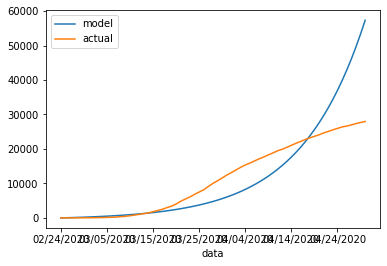

In [141]:
# actual data fitting
totdays = len(df_naz['deceduti'])
days = 60
tspan = np.arange(0, days, 1)
ydata = 1. * df_naz['deceduti'].iloc[:days]
initial_conditions = [initE, initI, initR, initN, initD]
def myfunc(t, beta, sigma, gamma, mu):
    initE, initI, initR, initN, initD = initial_conditions
    initS = initN - (initE + initI + initR + initD)
    res = odeint(ode_model, [initS, initE, initI, initR, initD], t, args=(beta, sigma, gamma, mu))
    return [item[-1] for item in res]
myfunc(tspan, 0.4, 0.2, 0.2, 0.2)
beta, sigma, gamma, mu = curve_fit(myfunc, xdata=tspan, ydata=ydata)[0]#, p0 = [0.4, 0.2, 0.2, 0.2])
model_deaths = pd.DataFrame(myfunc(range(totdays), beta, sigma, gamma, mu), index=df_naz['deceduti'].iloc[:totdays].index, columns=['model'])
model_deaths.plot(label='model')
df_naz['deceduti'].iloc[:totdays].plot(label='actual')
plt.legend()

In [133]:
def main(initE, initI, initR, initD, initN, R0, sigma_t, gamma_t, mu, days):
    sigma = 1/sigma_t
    gamma = 1/gamma_t
    beta = R0 * gamma
    initial_conditions = [initE, initI, initR, initN, initD]
    params = [beta, sigma, gamma, mu]
    tspan = np.arange(0, days, 1)
    sol = ode_solver(tspan, initial_conditions, params)
    S, E, I, R, D = sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3], sol[:, 4]
    
    # Create traces
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=tspan, y=S, mode='lines', name='Susceptible'))#,yaxis='y1'))
    fig.add_trace(go.Scatter(x=tspan, y=E, mode='lines', name='Exposed'))#,yaxis='y1'))
    fig.add_trace(go.Scatter(x=tspan, y=I, mode='lines', name='Infected'))#,yaxis='y1'))
    fig.add_trace(go.Scatter(x=tspan, y=R, mode='lines',name='Recovered'))#,yaxis='y1'))
    fig.add_trace(go.Scatter(x=tspan, y=D, mode='lines',name='Death'))#,yaxis='y2'))
    fig.add_trace(go.Scatter(x=tspan, y=1.5*df_naz['deceduti'].iloc[:days], 
                             mode='markers',name='actual infected'))#,yaxis='y2'))
    
    if days <= 30:
        step = 1
    elif days <= 90:
        step = 7
    else:
        step = 30
    
    fig.update_layout(title='Simulation of SEIRD Model',
                       xaxis_title='Day',
                       yaxis_title='Counts',
                       title_x=0.5,
                      width=900, height=600
                     )
    fig.update_xaxes(tickangle=-90, tickformat = None, tickmode='array', tickvals=np.arange(0, days + 1, step))
    fig.show()

In [134]:
beta, sigma, gamma, mu = curve_fit(myfunc, xdata=tspan, ydata=ydata)[0]#, p0 = [0.4, 0.2, 0.2, 0.2])
initN = 60000000
# S0 = 966000000
initE = 1
initI = 120
initR = 0
initD = 0
sigma_t = 1/sigma
gamma_t = 1/gamma
# mu = 0.014
R0 = beta/gamma
# beta = R0 * gamma
days = 150

/home/maurizio/anaconda3/envs/covid19/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



In [135]:
interact(main, 
         initE=widgets.IntSlider(min=0, max=100000, step=1, value=initE, description='initE', style=style, layout=slider_layout),
         initI=widgets.IntSlider(min=0, max=100000, step=10, value=initI, description='initI', style=style, layout=slider_layout),
         initR=widgets.IntSlider(min=0, max=100000, step=10, value=initR, description='initR', style=style, layout=slider_layout),
         initD=widgets.IntSlider(min=0, max=100000, step=10, value=initD, description='initD', style=style, layout=slider_layout),
         initN=widgets.IntSlider(min=0, max=1380000000, step=1000, value=initN, description='initN', style=style, layout=slider_layout),
#          beta=widgets.FloatSlider(min=0, max=4, step=0.01, value=beta, description='Infection rate', style=style, layout=slider_layout),
         R0 = widgets.FloatSlider(min=0, max=4, step=0.01, value=R0, description='Initial Reproduction number R0', style=style, layout=slider_layout),
         sigma_t=widgets.FloatSlider(min=0, max=40, step=0.01, value=sigma_t, description='Incubation period', style=style, layout=slider_layout),
         gamma_t=widgets.FloatSlider(min=0, max=40, step=0.01, value=gamma_t, description='Recovery period', style=style, layout=slider_layout),
         mu=widgets.FloatSlider(min=0, max=1, step=0.001, value=mu, description='Mortality rate', style=style, layout=slider_layout),
         days=widgets.IntSlider(min=1, max=600, step=7, value=days, description='Days', style=style, layout=slider_layout)
        );

interactive(children=(IntSlider(value=1, description='initE', layout=Layout(width='99%'), max=100000, style=Sl…

#### begin remove section

In [8]:
new_cases = df_naz['nuovi_positivi'].rolling(7).mean().dropna()

In [9]:
def IDEA(t,R_0,d):
    return (R_0 / (1+d)**t)**t

In [10]:
R_0, d = curve_fit(IDEA, xdata=range(len(new_cases)), ydata=new_cases)[0]
print(R_0)
print(d)

1.6995351381224317
0.00805933230361858


/home/maurizio/anaconda3/envs/covid19/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

overflow encountered in power



In [11]:
I_t = pd.Series(np.array([IDEA(t, R_0, d) for t in range(len(new_cases))]), index=new_cases.index)

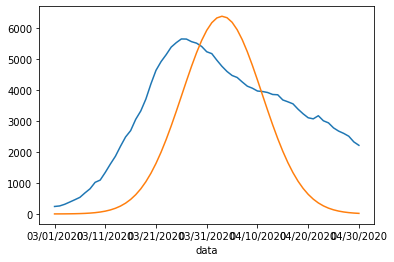

In [12]:
new_cases.plot()
plt.plot(I_t)

[Top](#top)